# Getis Ord Statistic Plots

In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

import sys
sys.path.append("/home/tommy/ml_drought")

In [2]:
[k for k in list(plt.rcParams.keys()) if "size" in k]

label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)
# plt.rcParams["font.size"]

In [3]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
%load_ext autoreload
%autoreload 2

# Load in all of the raw data (original)

In [6]:
# all_data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)

catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]

## Extra Processes

In [7]:
# Get the list of basins that we actually have results for
lstm_preds_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_preds_df["time"] = pd.to_datetime(lstm_preds_df["time"])
lstm_preds = lstm_preds_df.set_index(["station_id", "time"]).to_xarray()

VALID_BASINS = (lstm_preds_df["station_id"].unique())

In [8]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# load in shapefiles

In [9]:
import geopandas as gpd

assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
uk.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
79,Admin-0 country,0,2,United Kingdom,GB1,1,2,Country,United Kingdom,GBR,...,영국,Verenigd Koninkrijk,Wielka Brytania,Reino Unido,Великобритания,Storbritannien,Birleşik Krallık,Vương quốc Liên hiệp Anh và Bắc Ireland,英国,"MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55..."


In [10]:
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
# display(delta_df.head())
polygons = False

# create spatial dataframe
gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING')
)


if not polygons:
    static_df = static.to_dataframe()
    d = static_df[["gauge_lat", "gauge_lon"]]

    points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
#     points.name = "geometry"
#     delta_gdf = delta_gdf.drop("geometry", axis=1).join(points)
#     delta_gdf.crs = {'init' :'epsg:4326'}


# delta_gdf = delta_gdf.to_crs(epsg=4326)

# delta_gdf.head()

In [12]:
from typing import Tuple, List

def translate_model_str(model: str):
    if model.upper() == "SAC":
        model = "SACRAMENTO"
    elif model.upper() == "TOP":
        model = "TOPMODEL"
    return model

def read_model_gdf(file, model_at_end_of_str=True):
    if model_at_end_of_str:
        model = file.as_posix().split("/")[-1].split("_")[0].upper()
    else:
        model = file.as_posix().split("/")[-1].split("_")[-1].split(".")[0].upper()
    gdf = gpd.read_file(file)
    gdf["model"] = translate_model_str(model)
    return gdf


def bground_plot(ax = None):
    if ax is None:
        f, ax = plt.subplots()
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])

    ax.axis('off');
    return ax 


def create_sig_level_arrays(gdf) -> Tuple[List[pd.Series]]:
    most_sig = gdf["GiPValue"] < 0.01
    mid_sig = (gdf["GiPValue"] < 0.05) & (gdf["GiPValue"] > 0.01)
    low_sig = (gdf["GiPValue"] < 0.1) & (gdf["GiPValue"] > 0.05)
    not_sig = gdf["GiPValue"] > 0.1
    sig_levels = [most_sig, mid_sig, low_sig]
    
    return sig_levels, not_sig

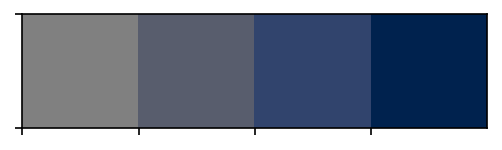

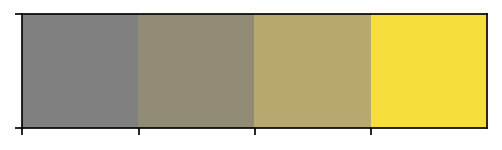

In [81]:
# sns.palplot(["grey", "#c3cabf", "#889fb8", "#4a77b0",])
sns.palplot(["grey", "#585d6d", "#31446d", "#00224e"])
sns.palplot(["grey", "#928c77", "#b6a86f", "#f6de3d"])

In [101]:
from typing import Optional


def plot_getis_ord_statistics(gdfs: List[gpd.GeoDataFrame], plot_conceptual: bool = True, delta: bool = False):
    # Overall settings
    lookup_color = {
        "coldspot": ["grey", "#c3cabf", "#889fb8", "#4a77b0",],
        "hotspot": ["grey", "#f1ba8b", "#de7d5c", "#c5463a"]
    }
    lookup_viridis_color = {
        "coldspot": ["grey", "#7bd250", "#9dd93b", "#fde726"],
        "hotspot": ["grey", "#3e4989", "#481d6f", "#450559"]
    }
    lookup_cividis_color = {
        "coldspot": ["grey", "#585d6d", "#31446d", "#00224e"],
        "hotspot": ["grey", "#928c77", "#b6a86f", "#f6de3d"]
    }

    label_base = ["Not Significant", "90% Confidence", "95% Confidence", "99% Confidence"]
    marker_sizes =  [1, 10, 15, 20]  #      [20, 15, 10, 1]

    # Create Plots
    if plot_conceptual:
        f, axs = plt.subplots(2, 3, figsize=(6*3, 4*2))
    else:
        f, axs = plt.subplots(1, 2, figsize=(6*2, 4*1))
        gdfs = [gdf for gdf in gdfs if any(np.isin(gdf["model"].unique(), ["EALSTM", "LSTM"]))]
        assert len(gdfs) < 3

    for ix, gdf in enumerate(gdfs):
        ax = axs[np.unravel_index(ix, axs.shape)]

        # sig_levels, not_sig = create_sig_level_arrays(gdf)

        ax = bground_plot(ax=ax)

        # plot for each significance level (stored in Gi Bin)
        groupby = gdf.groupby("Gi_Bin").groups
        for group in groupby.items():
            # group coded (-3, -2, -1, 0, 1, 2, 3)
            key = group[0]
            sig_ix = abs(key)
            indexes = group[-1]
            data = gdf.loc[indexes]
            spot_str = "coldspot" if key < 0 else "hotspot"
            colors = lookup_cividis_color[spot_str] if delta else lookup_color[spot_str] 
            if delta:
                label = "Small ∆NSE" + label_base[sig_ix] if key < 0 else "Large ∆NSE" + label_base[sig_ix]
            else:
                label = f"{spot_str.capitalize()} - " + label_base[sig_ix]
            data.plot(ax=ax, markersize=marker_sizes[sig_ix], color=colors[sig_ix], label=label)

        ax.set_title(gdf["model"][0].replace("SACRA", "Sacramento"))
    return axs

# Plot the NSE Hotspot / coldspots

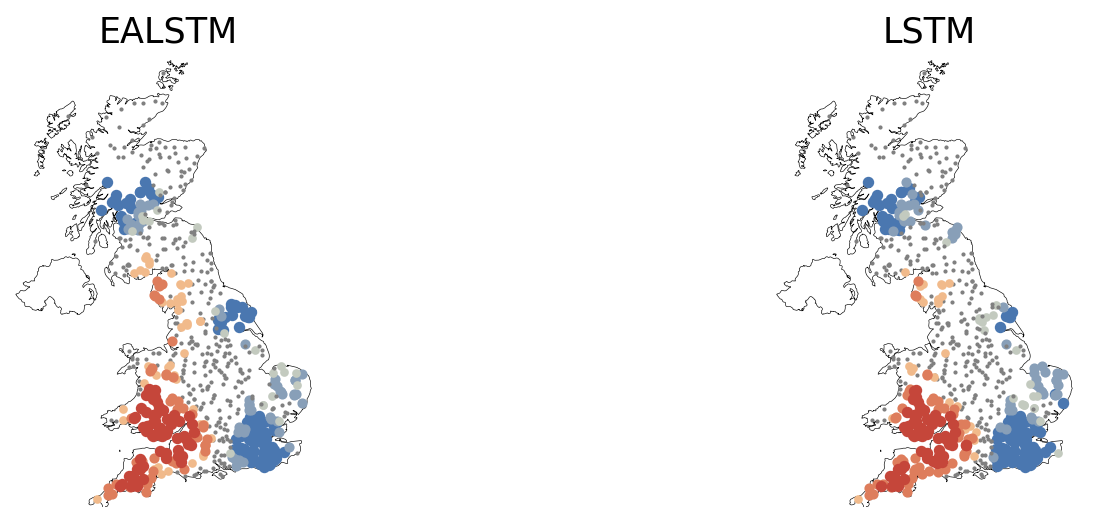

In [102]:
nse_shpfiles = [d for d in (data_dir / "RUNOFF/For_Tommy").glob("*_HotSpots.shp")]
gdfs = [read_model_gdf(file) for file in nse_shpfiles]
axs = plot_getis_ord_statistics(gdfs, plot_conceptual=False);

In [103]:
# # # GET THE LEGEND!! 
# # Overall settings
# lookup_color = {
#     "coldspot": ["grey", "#c3cabf", "#889fb8", "#4a77b0",],
#     "hotspot": ["grey", "#f1ba8b", "#de7d5c", "#c5463a"]
# }
# label_base = ["Not Significant", "90% Confidence", "95% Confidence", "99% Confidence"]
# marker_sizes =  [1, 10, 15, 20]  #      [20, 15, 10, 1]

# f, ax = plt.subplots(figsize=(12, 20))
# file = nse_shpfiles[-1]
# gdf = read_model_gdf(file)
# groupby = gdf.groupby("Gi_Bin").groups
# for group in groupby.items():
#     # group coded (-3, -2, -1, 0, 1, 2, 3)
#     key = group[0]
#     sig_ix = abs(key)
#     indexes = group[-1]
#     data = gdf.loc[indexes]
#     spot_str = "coldspot" if key < 0 else "hotspot"
#     colors = lookup_color[spot_str]
#     label = f"{spot_str.capitalize()} - " + label_base[sig_ix]
#     data.plot(ax=ax, markersize=marker_sizes[sig_ix], color=colors[sig_ix], label=label)
# ax.legend()

# Plot the DeltaNSE hotspot/coldspot (vs. LSTM)

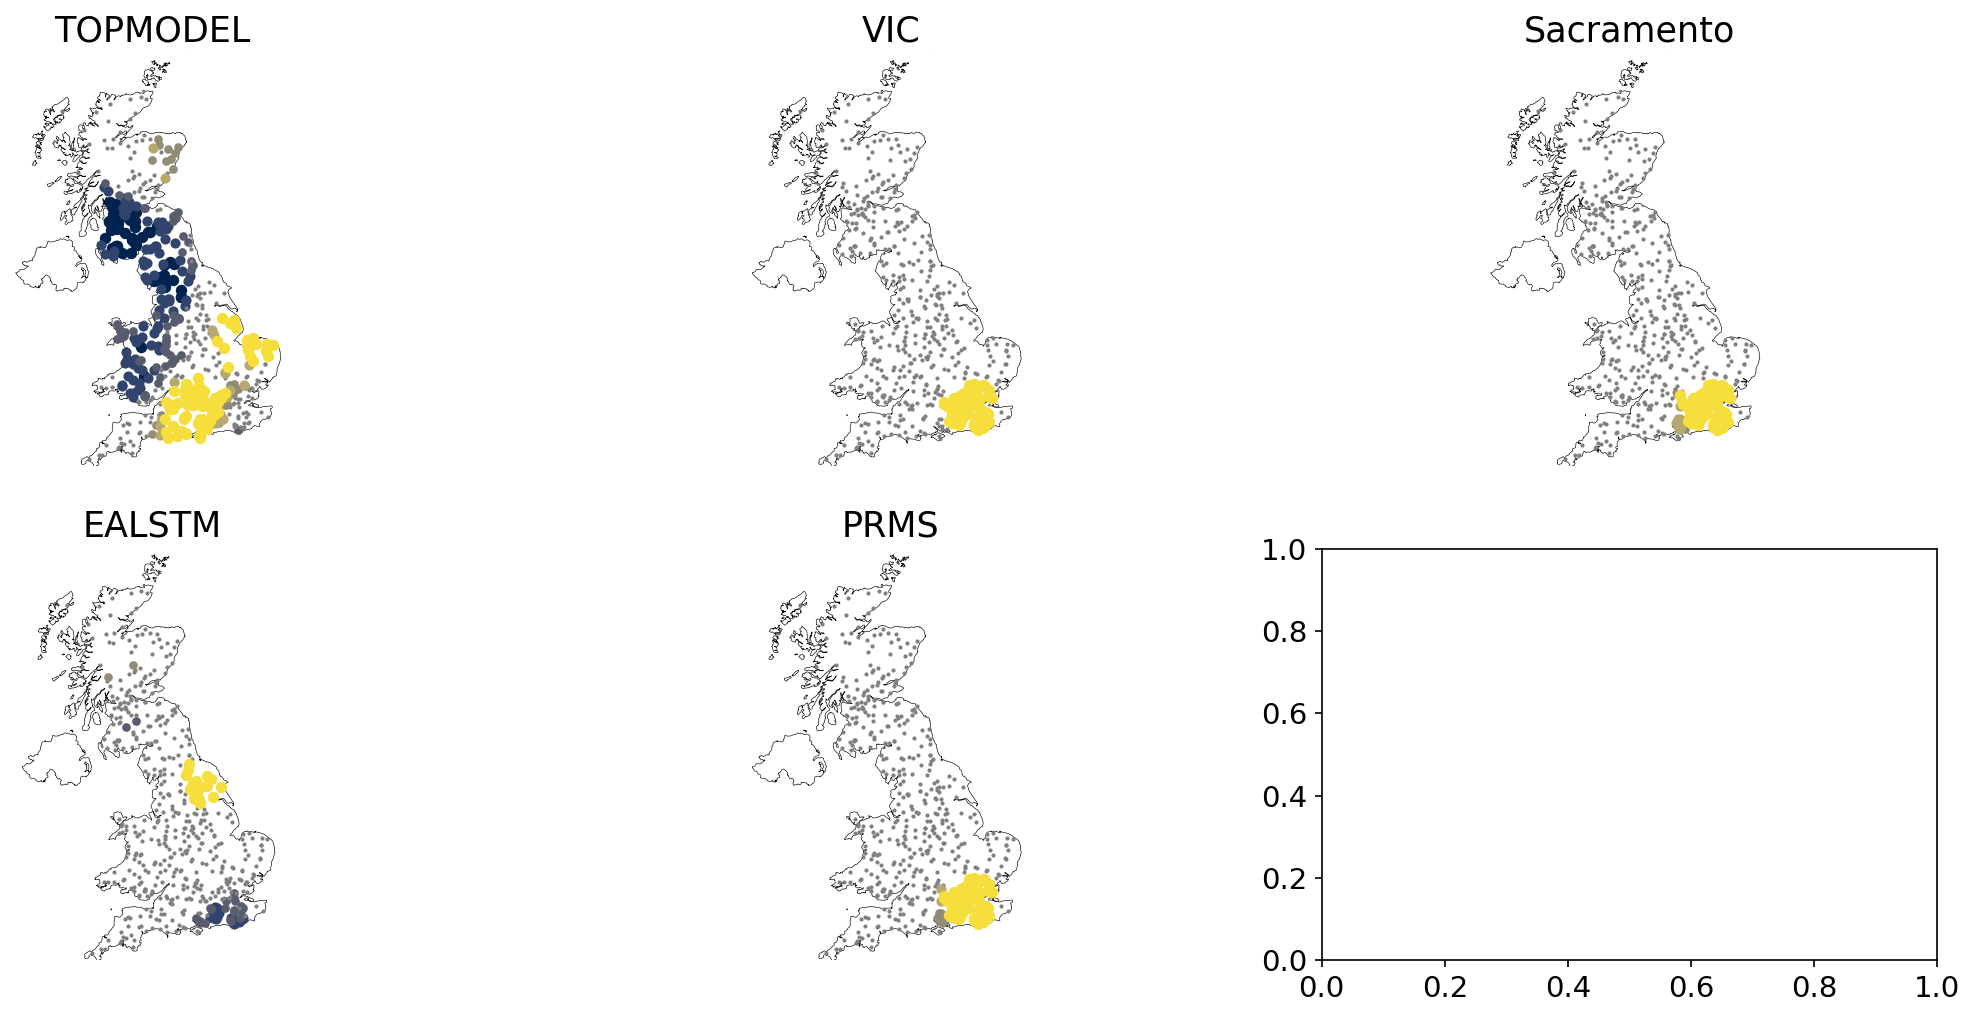

In [104]:
nse_shapefiles = [d for d in (data_dir / "RUNOFF/For_Tommy").glob("lstm_delta*.shp")]
gdfs = [read_model_gdf(file, model_at_end_of_str=False) for file in nse_shapefiles]
axs = plot_getis_ord_statistics(gdfs, delta=True);

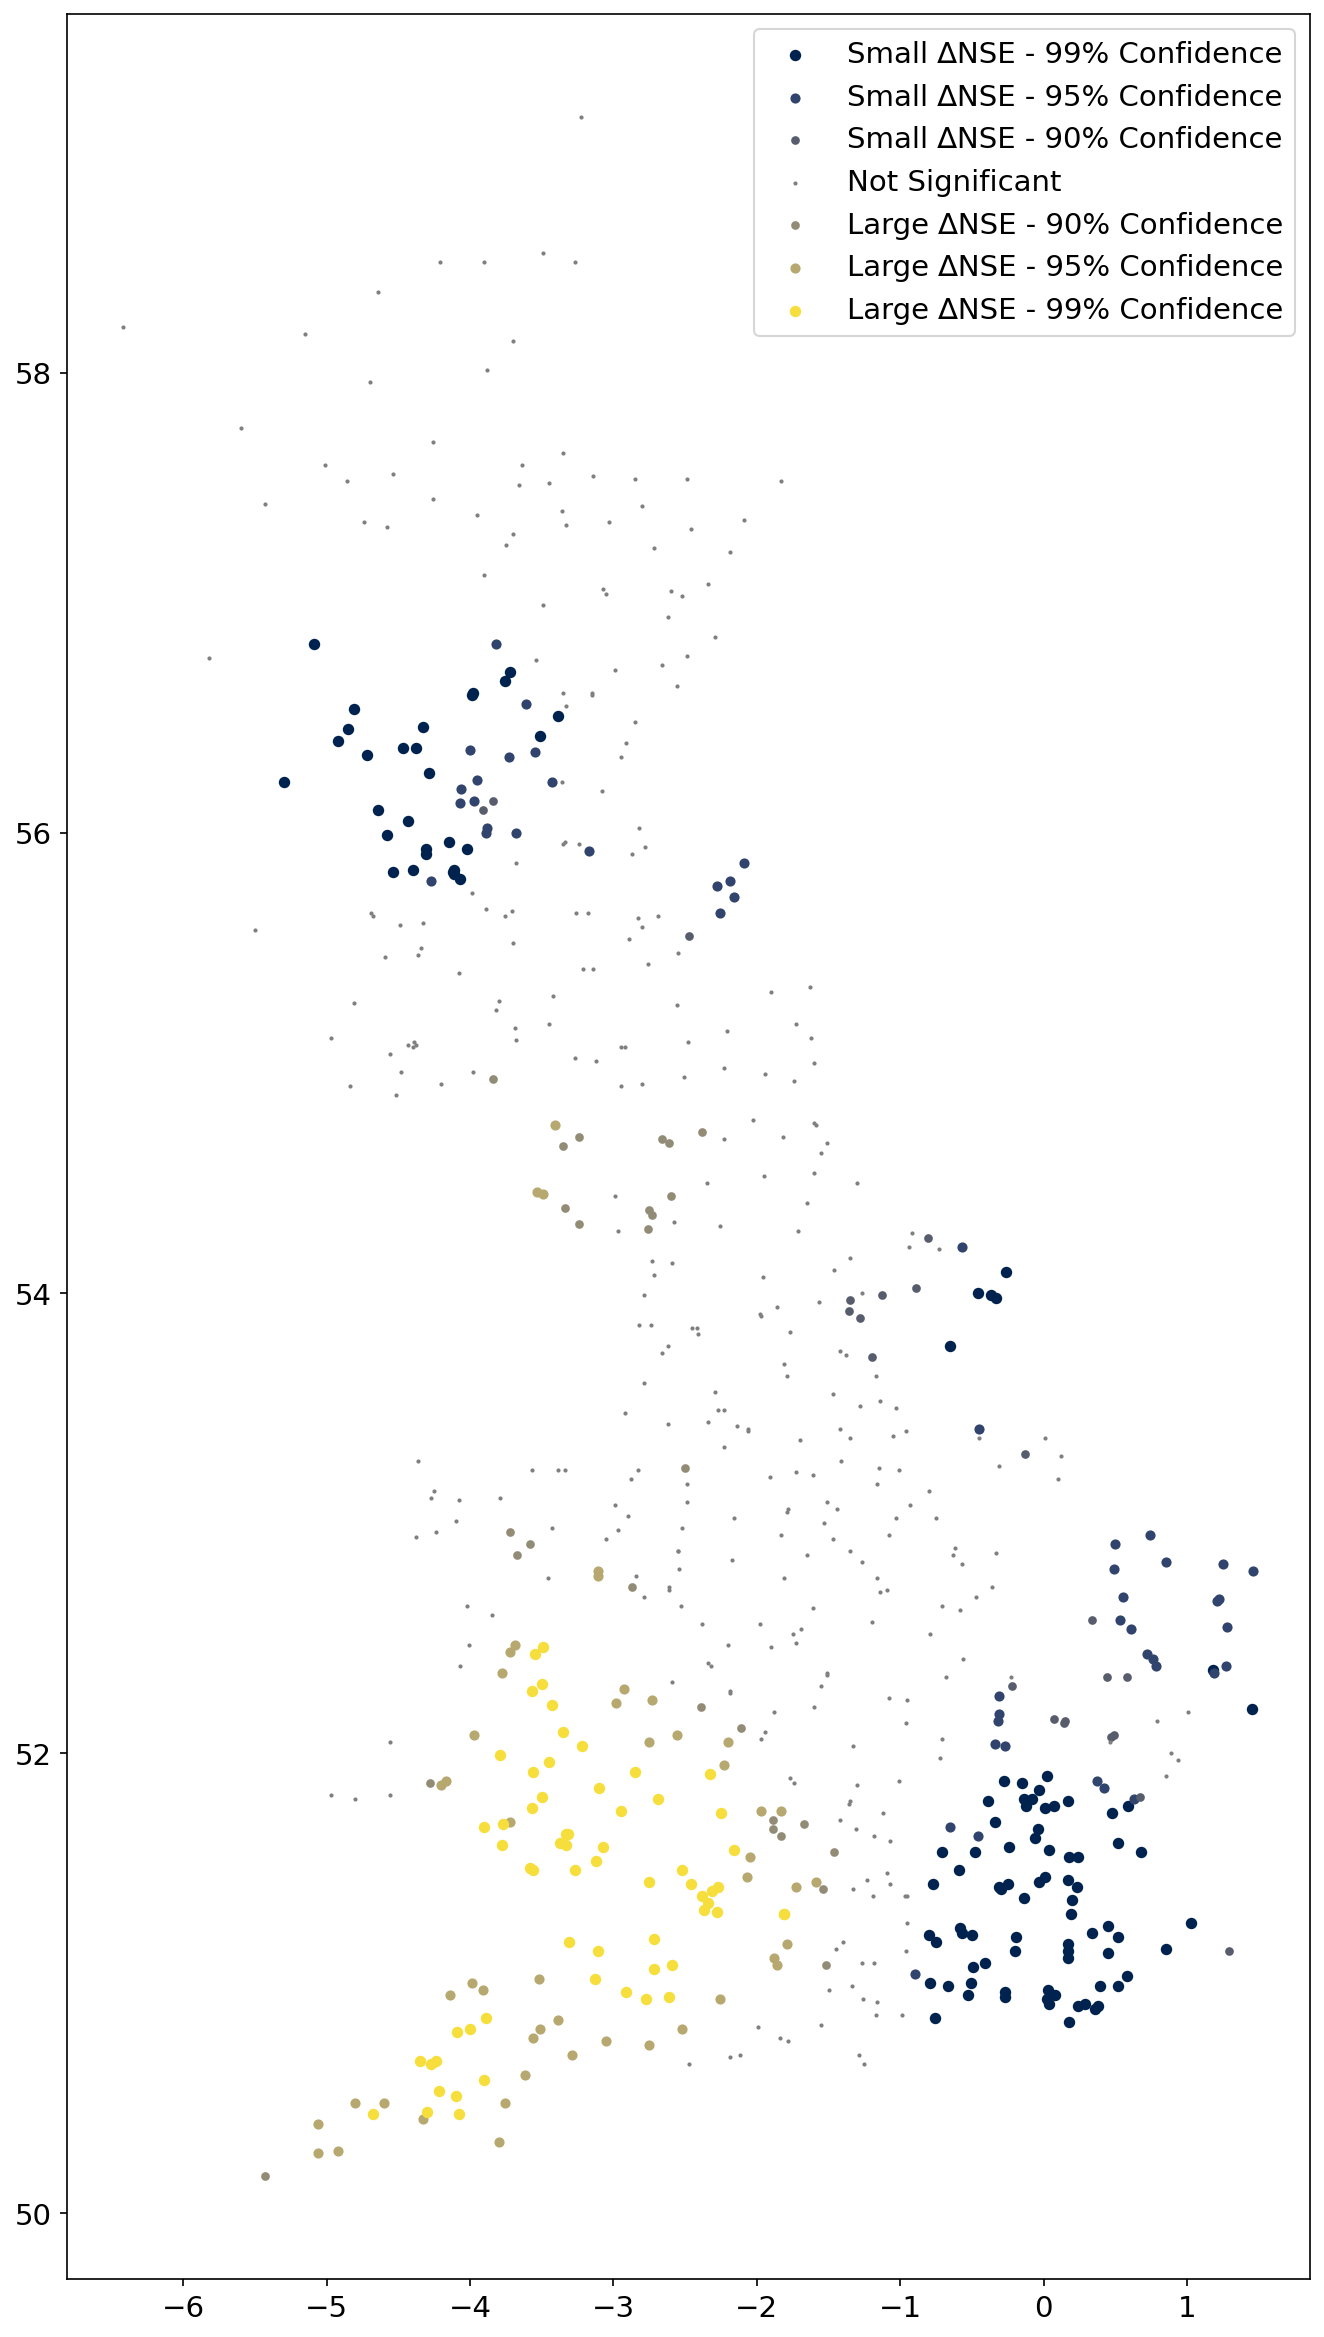

In [96]:
# # # GET THE LEGEND!! 
# Overall settings
lookup_color = {
    "coldspot": ["grey", "#c3cabf", "#889fb8", "#4a77b0",],
    "hotspot": ["grey", "#f1ba8b", "#de7d5c", "#c5463a"]
}
label_base = ["Not Significant", "90% Confidence", "95% Confidence", "99% Confidence"]
marker_sizes =  [1, 10, 15, 20]  #      [20, 15, 10, 1]

lookup_cividis_color = {
    "coldspot": ["grey", "#585d6d", "#31446d", "#00224e"],
    "hotspot": ["grey", "#928c77", "#b6a86f", "#f6de3d"]
}

f, ax = plt.subplots(figsize=(12, 20))
file = nse_shpfiles[-1]
gdf = read_model_gdf(file)
# plot for each significance level (stored in Gi Bin)
groupby = gdf.groupby("Gi_Bin").groups
for group in groupby.items():
    # group coded (-3, -2, -1, 0, 1, 2, 3)
    key = group[0]
    sig_ix = abs(key)
    indexes = group[-1]
    data = gdf.loc[indexes]
    spot_str = "coldspot" if key < 0 else "hotspot"
    colors = lookup_cividis_color[spot_str]
    if key == 0:
        label = "Not Significant"
    else:
        label = "Small ∆NSE - " + label_base[sig_ix] if key < 0 else "Large ∆NSE - " + label_base[sig_ix]
    data.plot(ax=ax, markersize=marker_sizes[sig_ix], color=colors[sig_ix], label=label)
ax.legend()

# Plot Delta NSE EALSTM

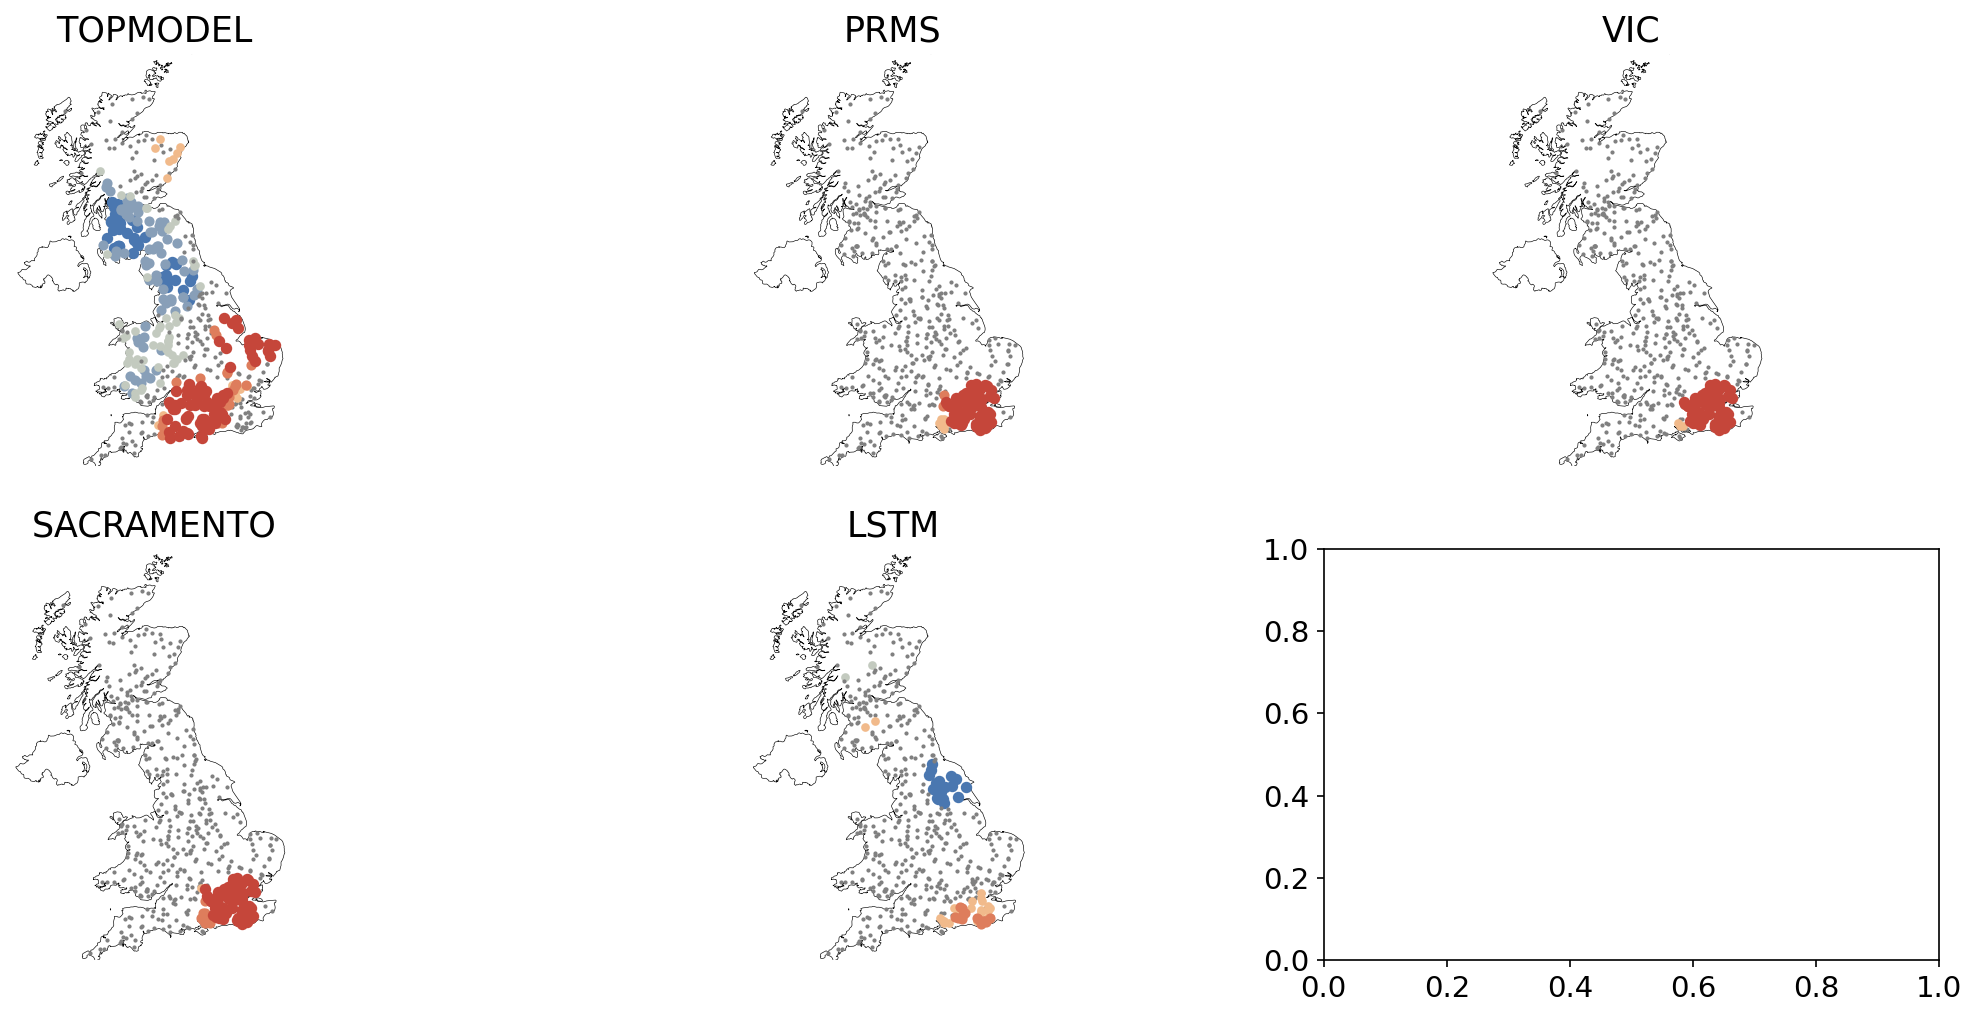

In [18]:
nse_shapefiles = [d for d in (data_dir / "RUNOFF/For_Tommy").glob("ealstm_delta*.shp")]
gdfs = [read_model_gdf(file, model_at_end_of_str=False) for file in nse_shapefiles]
axs = plot_getis_ord_statistics(gdfs);

# Plot Bias Hotspot/Coldspots

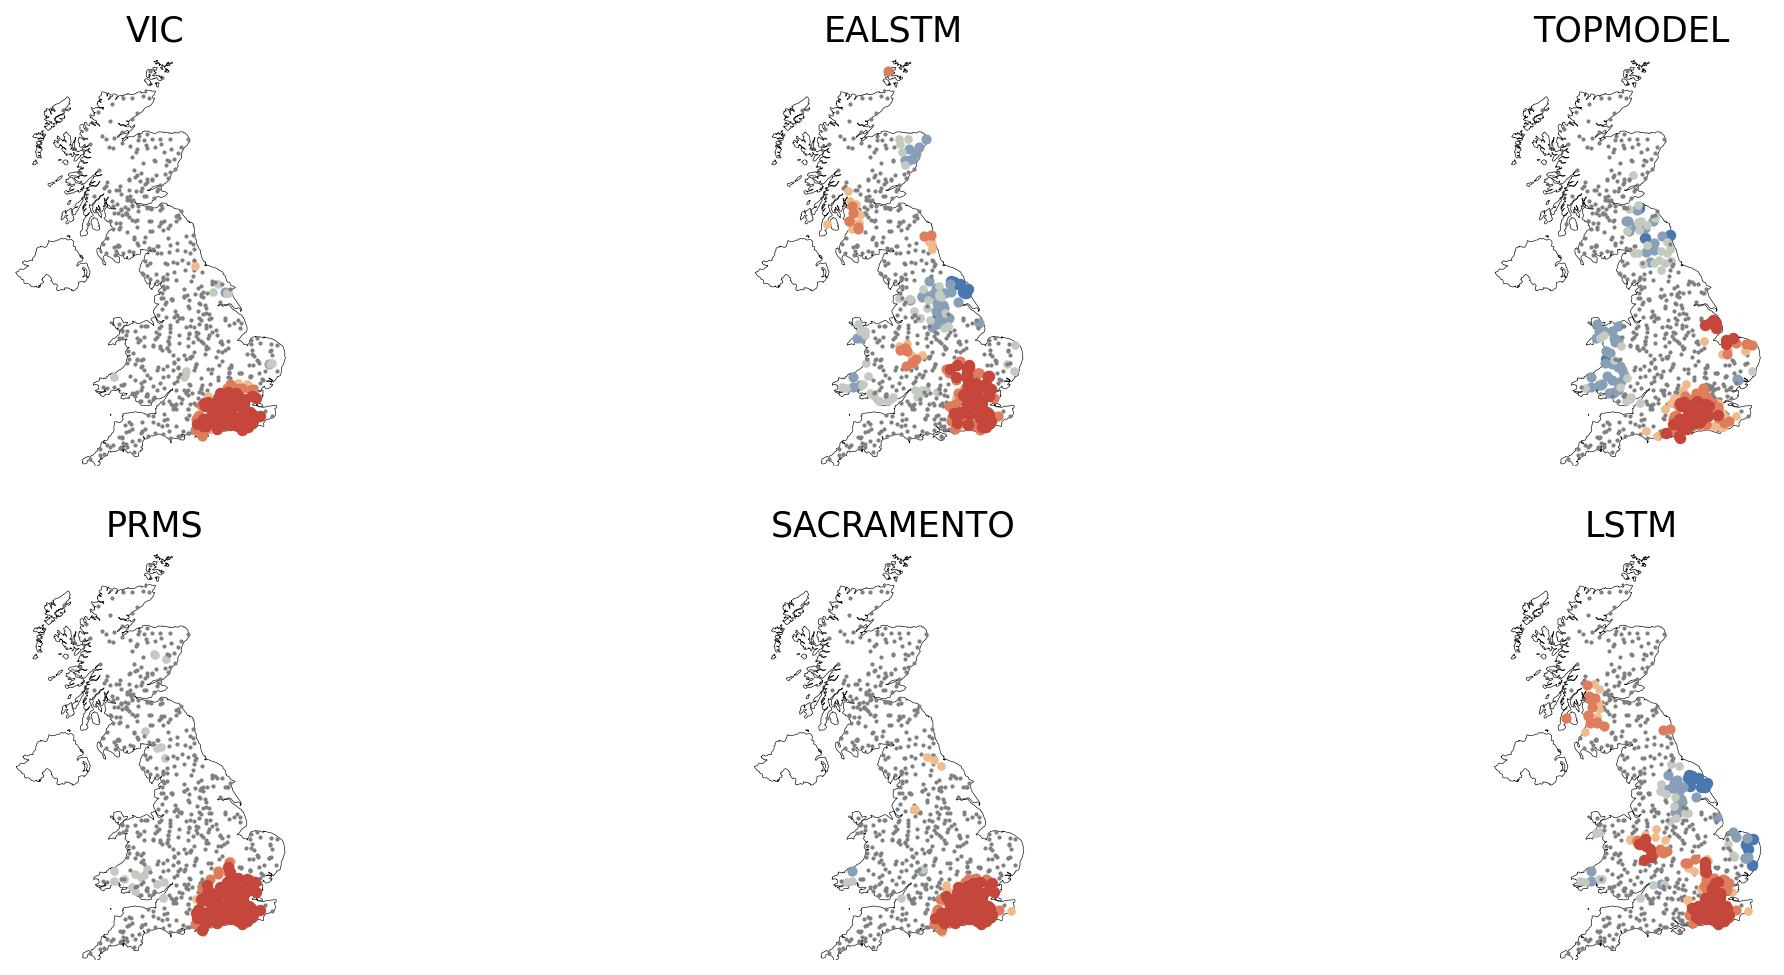

In [19]:
nse_shapefiles = [d for d in (data_dir / "RUNOFF/For_Tommy").glob("*_HotSpotsbias.shp")]
gdfs = [read_model_gdf(file, model_at_end_of_str=True) for file in nse_shapefiles]
axs = plot_getis_ord_statistics(gdfs);

# Plot hotspot coldspots of KGE

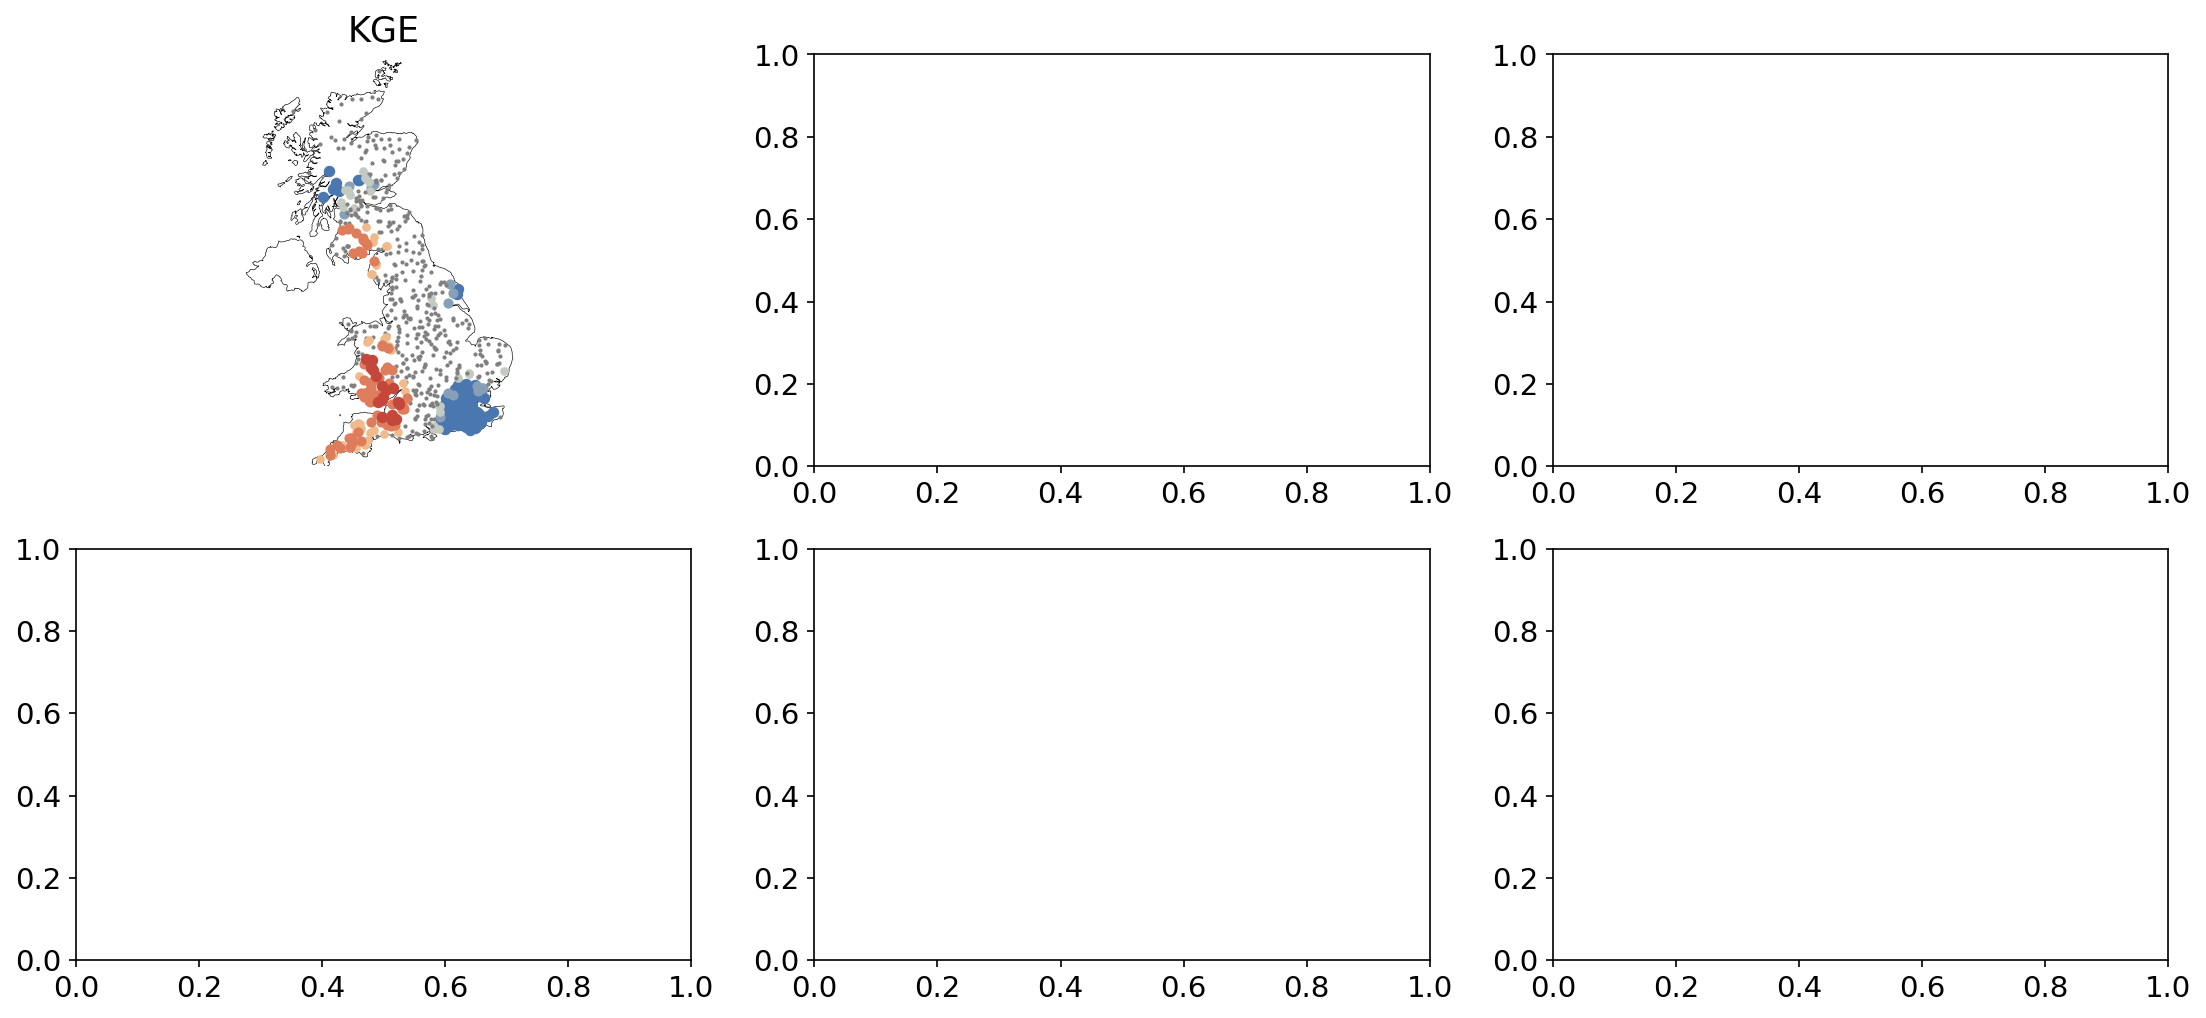

In [20]:
nse_shapefiles = [d for d in (data_dir / "RUNOFF/For_Tommy").glob("kge_lstm_hotpoint.shp")]
gdfs = [read_model_gdf(file, model_at_end_of_str=True) for file in nse_shapefiles]
axs = plot_getis_ord_statistics(gdfs);